In [1]:
%matplotlib inline
# %reload_ext autoreload
# %autoreload 2

import sys, warnings
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainutils, datastream, augments

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

warnings.filterwarnings('ignore', '.*output shape of zoom.*') # turn off stupid zoom warning

imwidth = 256
imheight = 256
numimgs = 1000

In [2]:
dataset=[trainutils.createTestImage(imwidth,imheight,noiseMax=0.8) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
segin=np.concatenate([(d[1],) for d in dataset])

In [3]:
%%time
dsrc=datastream.ArraySource(imgin,segin,orderType=datastream.OrderType.SHUFFLE)
a=dsrc.getSubArrays(slice(0,500))
b=dsrc.getSubArrays(slice(500,1000))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 58.9 µs


1.22 µs ± 6.33 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


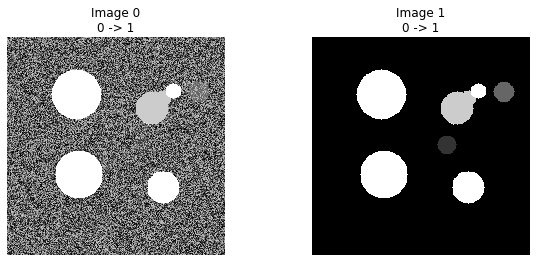

In [4]:
it=iter(dsrc)
%timeit next(it)

img,seg=next(it)
f,a=trainutils.showImages(img[...,0],seg/seg.max())

43.3 µs ± 7.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
44.5 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
(256, 256, 1) (256, 256)
31.2 µs ± 4.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
(256, 256, 1) (256, 256)


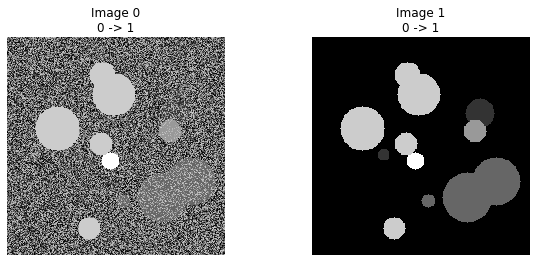

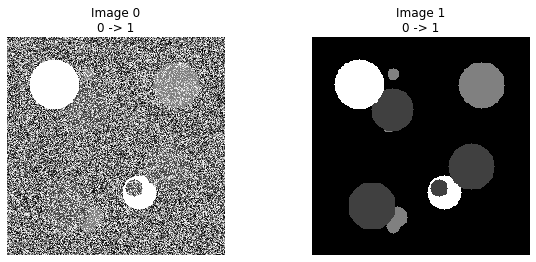

In [5]:
tsrc=datastream.ThreadBufferStream(dsrc)
it=iter(tsrc)
%timeit next(it)

imgs,segs=next(it)

tsrc1=datastream.ThreadBufferStream(dsrc)
it1=iter(tsrc1)
%timeit next(it1)

imgs,segs=next(it1)

print(imgs.shape,segs.shape)
f,a=trainutils.showImages(imgs[...,0],segs/segs.max())
del it # kill thread
del it1

with tsrc:
    it=iter(tsrc)
    %timeit next(it)
    imgs,segs=next(it)
    print(imgs.shape,segs.shape)
    
f,a=trainutils.showImages(imgs[...,0],segs/segs.max())

In [6]:
for i,(imgs,segs) in zip(range(5),tsrc):
    print(i,imgs.shape,segs.shape)

0 (256, 256, 1) (256, 256)
1 (256, 256, 1) (256, 256)
2 (256, 256, 1) (256, 256)
3 (256, 256, 1) (256, 256)
4 (256, 256, 1) (256, 256)


4.05 ms ± 152 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(20, 256, 256, 1) (20, 256, 256)


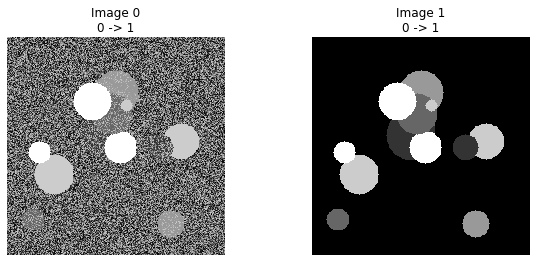

In [7]:
bsrc=datastream.BatchStream(dsrc,20)
it=iter(bsrc)
%timeit next(it)

imgs,segs=next(it)
print(imgs.shape,segs.shape)
f,a=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

29.5 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.7 ms ± 111 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


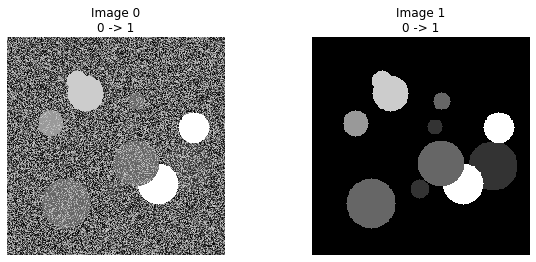

In [8]:
augs=[
    augments.rot90, augments.transpose, augments.flip,
]

asrc=datastream.ThreadAugmentStream(dsrc,100,augments=augs)

it=iter(asrc.getLocalGen())
%timeit next(it)

it=iter(asrc)
%timeit next(it)

imgs,segs=next(it)
_=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

52.3 ms ± 439 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
109 ms ± 5.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


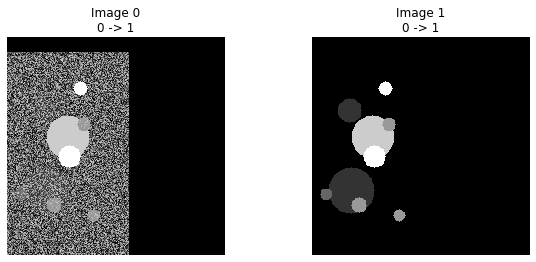

In [9]:
augs=[
    partial(augments.shift,prob=1.0,nonzeroIndex=1)
]

asrc=datastream.ThreadAugmentStream(dsrc,100,augments=augs)

it=iter(asrc.getLocalGen())
%timeit next(it)

it=iter(asrc)
%timeit next(it)

imgs,segs=next(it)
_=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

665 ms ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
142 ms ± 3.97 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


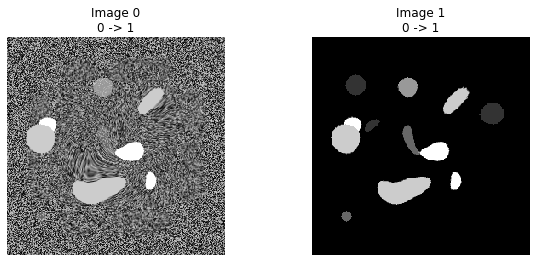

In [10]:
augs=[
    partial(augments.deformPIL,prob=1.0)
]

asrc=datastream.ThreadAugmentStream(dsrc,100,augments=augs)

it=iter(asrc.getLocalGen())
%timeit next(it)

it=iter(asrc)
%timeit next(it)

imgs,segs=next(it)
_=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

121 ms ± 744 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
90.8 ms ± 4.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


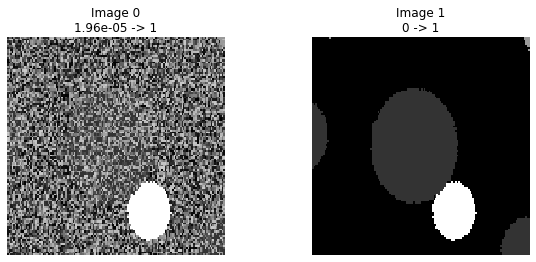

In [11]:
augs=[
    partial(augments.rotateZoomPIL,prob=1.0)
]

asrc=datastream.ThreadAugmentStream(dsrc,100,augments=augs)

it=iter(asrc.getLocalGen())
%timeit next(it)

it=iter(asrc)
%timeit next(it)

imgs,segs=next(it)
_=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())

413 ms ± 29.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
135 ms ± 1.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


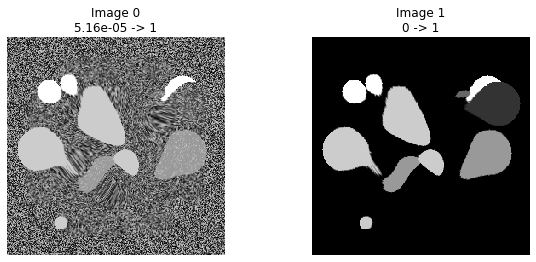

In [12]:
augs=[
    lambda i,m:(i,m.astype(np.float32)),
    augments.rot90, augments.transpose, augments.flip,
    augments.deformPIL,
    augments.rotateZoomPIL,
    augments.shift,
]

asrc=datastream.ThreadAugmentStream(dsrc,100,augments=augs)

it=iter(asrc.getLocalGen())
%timeit next(it)

it=iter(asrc)
%timeit next(it)

imgs,segs=next(it)
_=trainutils.showImages(imgs[0,...,0],segs[0]/segs.max())